In [1]:
import tensorflow as tf

IMAGE_SIZE = (256, 256)
NUM_CLASSES = 3

import tensorflow as tf
import random
import numpy as np
import os

SEED = 1998
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)


2022-11-20 15:57:48.753874: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 15:57:48.919566: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-20 15:57:49.577350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-20 15:57:49.577441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

### 모델

UNET가 유사한 모델로 구성함  
* 1/10000로 스케일링함  
* 채널 수와 깊이를 줄임
* Dropout을 0.2로 추가함


In [2]:
import tensorflow as tf

# https://github.com/zhixuhao/unet/blob/master/model.py
def unet(input_size=(256, 256, 1), num_classes=3):
    inputs = tf.keras.Input(input_size)
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 10000)(inputs)
    conv1 = tf.keras.layers.Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(x)
    conv1 = tf.keras.layers.Dropout(0.2)(conv1)
    conv1 = tf.keras.layers.Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv1)
    conv1 = tf.keras.layers.Dropout(0.2)(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool1)
    conv2 = tf.keras.layers.Dropout(0.2)(conv2)
    conv2 = tf.keras.layers.Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv2)
    conv2 = tf.keras.layers.Dropout(0.2)(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(
        256, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool2)
    conv3 = tf.keras.layers.Dropout(0.2)(conv3)
    conv3 = tf.keras.layers.Conv2D(
        256, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv3)
    conv3 = tf.keras.layers.Dropout(0.2)(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(
        512, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool3)
    conv4 = tf.keras.layers.Dropout(0.2)(conv4)
    conv4 = tf.keras.layers.Conv2D(
        512, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv4)
    conv4 = tf.keras.layers.Dropout(0.2)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = tf.keras.layers.Conv2D(
        256, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(pool4)
    conv5 = tf.keras.layers.Dropout(0.2)(conv5)
    conv5 = tf.keras.layers.Conv2D(
        256, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv5)
    conv5 = tf.keras.layers.Dropout(0.2)(conv5)

    up6 = tf.keras.layers.Conv2D(
        128, 2, activation="relu", padding="same", kernel_initializer="he_normal"
    )(tf.keras.layers.UpSampling2D(size=(2, 2))(conv5))
    merge6 = tf.keras.layers.concatenate([conv4, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge6)
    conv6 = tf.keras.layers.Dropout(0.2)(conv6)
    conv6 = tf.keras.layers.Conv2D(
        128, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv6)
    conv6 = tf.keras.layers.Dropout(0.2)(conv6)

    up7 = tf.keras.layers.Conv2D(
        64, 2, activation="relu", padding="same", kernel_initializer="he_normal"
    )(tf.keras.layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge7)
    conv7 = tf.keras.layers.Dropout(0.2)(conv7)
    conv7 = tf.keras.layers.Conv2D(
        64, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv7)
    conv7 = tf.keras.layers.Dropout(0.2)(conv7)

    up8 = tf.keras.layers.Conv2D(
        32, 2, activation="relu", padding="same", kernel_initializer="he_normal"
    )(tf.keras.layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
    conv8 = tf.keras.layers.Conv2D(
        32, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge8)
    conv8 = tf.keras.layers.Dropout(0.2)(conv8)
    conv8 = tf.keras.layers.Conv2D(
        32, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv8)
    conv8 = tf.keras.layers.Dropout(0.2)(conv8)

    up9 = tf.keras.layers.Conv2D(
        16, 2, activation="relu", padding="same", kernel_initializer="he_normal"
    )(tf.keras.layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)
    conv9 = tf.keras.layers.Conv2D(
        16, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(merge9)
    conv9 = tf.keras.layers.Dropout(0.2)(conv9)
    conv9 = tf.keras.layers.Conv2D(
        16, 3, activation="relu", padding="same", kernel_initializer="he_normal"
    )(conv9)
    conv9 = tf.keras.layers.Dropout(0.2)(conv9)
    conv9 = tf.keras.layers.Conv2D(
        num_classes,
        3,
        activation="relu",
        padding="same",
        kernel_initializer="he_normal",
    )(conv9)
    conv10 = tf.keras.layers.Conv2D(num_classes, 1, activation="softmax")(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model


model = unet()
model.summary()


2022-11-20 15:57:50.632721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-20 15:57:50.642983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-20 15:57:50.643569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-20 15:57:50.644601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [3]:
import os

TRAIN_DATA_DIR = os.path.join(os.curdir, "dataset", "train", "data")
TRAIN_LABEL_DIR = os.path.join(os.curdir, "dataset", "train", "label")
VAL_DATA_DIR = os.path.join(os.curdir, "dataset", "validation", "data")
VAL_LABEL_DIR = os.path.join(os.curdir, "dataset", "validation", "label")


def get_filenames(data_dir):
    return [filename for filename in sorted(os.listdir(data_dir))]


get_filenames(TRAIN_DATA_DIR)


['HFH_001_051.npy',
 'HFH_001_052.npy',
 'HFH_001_053.npy',
 'HFH_001_054.npy',
 'HFH_001_055.npy',
 'HFH_001_056.npy',
 'HFH_001_057.npy',
 'HFH_001_058.npy',
 'HFH_001_059.npy',
 'HFH_001_060.npy',
 'HFH_001_061.npy',
 'HFH_001_062.npy',
 'HFH_001_063.npy',
 'HFH_001_064.npy',
 'HFH_001_065.npy',
 'HFH_001_066.npy',
 'HFH_001_067.npy',
 'HFH_001_068.npy',
 'HFH_001_069.npy',
 'HFH_001_070.npy',
 'HFH_002_047.npy',
 'HFH_002_048.npy',
 'HFH_002_049.npy',
 'HFH_002_050.npy',
 'HFH_002_051.npy',
 'HFH_002_052.npy',
 'HFH_002_053.npy',
 'HFH_002_054.npy',
 'HFH_002_055.npy',
 'HFH_002_056.npy',
 'HFH_002_057.npy',
 'HFH_002_058.npy',
 'HFH_002_059.npy',
 'HFH_002_060.npy',
 'HFH_002_061.npy',
 'HFH_002_062.npy',
 'HFH_002_063.npy',
 'HFH_002_064.npy',
 'HFH_003_048.npy',
 'HFH_003_049.npy',
 'HFH_003_050.npy',
 'HFH_003_051.npy',
 'HFH_003_052.npy',
 'HFH_003_053.npy',
 'HFH_003_054.npy',
 'HFH_003_055.npy',
 'HFH_003_056.npy',
 'HFH_003_057.npy',
 'HFH_003_058.npy',
 'HFH_003_059.npy',


In [4]:
def get_filenames_5fold(filenames):
    filenames_5fold = []
    for _ in range(5):
        filenames_5fold.append([])
    for filename in filenames:
        index = (int(filename.split("_")[1]) - 1) // 5
        filenames_5fold[index].append(filename)
    return filenames_5fold


for item in get_filenames_5fold(get_filenames(TRAIN_DATA_DIR)):
    print(len(item))


94
89
93
96
87


In [5]:
import numpy as np
import pandas as pd


def yield_dataset_in(filenames_5fold, index, data_dir, label_dir):
    for filename in filenames_5fold[index]:
        with open(os.path.join(data_dir, filename), "rb") as f:
            data = np.load(f).astype(np.float32)[..., np.newaxis]
        with open(os.path.join(label_dir, filename), "rb") as f:
            label = np.load(f).astype(int)
        yield data, label


for data, label in yield_dataset_in(
    get_filenames_5fold(get_filenames(VAL_DATA_DIR)), 1, VAL_DATA_DIR, VAL_LABEL_DIR
):
    print(data.shape, data.dtype)
    print(pd.Series(data.flatten()).value_counts())
    break


(256, 256, 1) float32
1.0     15334
2.0     14017
3.0     10434
0.0     10041
4.0      6672
5.0      4229
6.0      2310
7.0      1315
8.0       682
9.0       291
10.0      125
11.0       53
12.0       23
13.0        6
14.0        2
16.0        1
15.0        1
dtype: int64


In [6]:
import numpy as np
import pandas as pd


def yield_dataset_except(filenames_5fold, index, data_dir, label_dir):
    for filenames in filenames_5fold[:index] + filenames_5fold[index + 1 :]:
        for filename in filenames:
            with open(os.path.join(data_dir, filename), "rb") as f:
                data = np.load(f).astype(np.float32)[..., np.newaxis]
            with open(os.path.join(label_dir, filename), "rb") as f:
                label = np.load(f).astype(int)
            yield data, label


for data, label in yield_dataset_except(
    get_filenames_5fold(get_filenames(TRAIN_DATA_DIR)), 1, TRAIN_DATA_DIR, TRAIN_LABEL_DIR
):
    print(data.shape, data.dtype)
    print(pd.Series(data.flatten()).value_counts())
    print(label.shape, data.dtype)
    print(pd.Series(label.flatten()).value_counts())
    break


(256, 256, 1) float32
1.0      3220
2.0      3053
3.0      3005
4.0      2644
5.0      2493
         ... 
257.0       1
263.0       1
226.0       1
234.0       1
237.0       1
Length: 253, dtype: int64
(256, 256, 3) float32
0    131072
1     65536
dtype: int64


In [7]:
import tensorflow as tf


def get_dataset_in(filenames_5fold, index, data_dir, label_dir):
    output_signature = (
        tf.TensorSpec(shape=(*IMAGE_SIZE, 1)),
        tf.TensorSpec(shape=(*IMAGE_SIZE, 3)),
    )
    return tf.data.Dataset.from_generator(
        lambda: yield_dataset_in(filenames_5fold, index, data_dir, label_dir),
        output_signature=output_signature,
    )


get_dataset_in(
    get_filenames_5fold(get_filenames(TRAIN_DATA_DIR)),
    0,
    TRAIN_DATA_DIR,
    TRAIN_LABEL_DIR,
)


<FlatMapDataset element_spec=(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None))>

In [8]:
def get_dataset_except(filenames_5fold, index, data_dir, label_dir):
    output_signature = (
        tf.TensorSpec(shape=(*IMAGE_SIZE, 1)),
        tf.TensorSpec(shape=(*IMAGE_SIZE, 3)),
    )
    return tf.data.Dataset.from_generator(
        lambda: yield_dataset_except(filenames_5fold, index, data_dir, label_dir),
        output_signature=output_signature,
    )


get_dataset_in(
    get_filenames_5fold(get_filenames(TRAIN_DATA_DIR)),
    0,
    TRAIN_DATA_DIR,
    TRAIN_LABEL_DIR,
)


<FlatMapDataset element_spec=(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None))>

In [9]:
def get_train_set(data_dir, label_dir):
    return get_dataset_except(
        get_filenames_5fold(get_filenames(data_dir)), 4, data_dir, label_dir
    )


def get_validation_set(data_dir, label_dir):
    return get_dataset_in(
        get_filenames_5fold(get_filenames(data_dir)), 4, data_dir, label_dir
    )


train_dataset = get_train_set(TRAIN_DATA_DIR, TRAIN_LABEL_DIR)
val_dataset = get_validation_set(VAL_DATA_DIR, VAL_LABEL_DIR)
print(train_dataset)
print(val_dataset)


<FlatMapDataset element_spec=(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None))>
<FlatMapDataset element_spec=(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None))>


In [10]:
from typing import Callable, Union
from tensorflow.keras import backend as K

# https://github.com/maxvfischer/keras-image-segmentation-loss-functions/blob/master/losses/multiclass_losses.py
def multiclass_weighted_cross_entropy(
    class_weights: list, is_logits: bool = False
) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Multi-class weighted cross entropy.
        WCE(p, p̂) = −Σp*log(p̂)*class_weights
    Used as loss function for multi-class image segmentation with one-hot encoded masks.
    :param class_weights: Weight coefficients (list of floats)
    :param is_logits: If y_pred are logits (bool)
    :return: Weighted cross entropy loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)

    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Computes the weighted cross entropy.
        :param y_true: Ground truth (tf.Tensor, shape=(None, None, None, None))
        :param y_pred: Predictions (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :return: Weighted cross entropy (tf.Tensor, shape=(<BATCH_SIZE>,))
        """
        assert len(class_weights) == y_pred.shape[-1], (
            f"Number of class_weights ({len(class_weights)}) needs to be the same as number "
            f"of classes ({y_pred.shape[-1]})"
        )

        if is_logits:
            y_pred = softmax(y_pred, axis=-1)

        y_pred = K.clip(
            y_pred, K.epsilon(), 1 - K.epsilon()
        )  # To avoid unwanted behaviour in K.log(y_pred)

        # p * log(p̂) * class_weights
        wce_loss = y_true * K.log(y_pred) * class_weights

        # Average over each data point/image in batch
        axis_to_reduce = range(1, K.ndim(wce_loss))
        wce_loss = K.mean(wce_loss, axis=axis_to_reduce)

        return -wce_loss

    return loss


### Loss

주어진 데이터에는 배경(classs 0)이 많기 때문에 가중치를 적용한 cross entropy를 사용  
가중치를 각각 [10, 100, 100]로 줌

### Metrics

- 배경을 제외한 Mean IoU
- 배경을 포함한 Mean IoU


In [11]:
model.compile(
    tf.keras.optimizers.Adam(learning_rate=2e-4),
    multiclass_weighted_cross_entropy([10.0, 100.0, 100.0]),
    [
        tf.keras.metrics.OneHotMeanIoU(
            ignore_class=0, num_classes=3, name="MeanIOU_no_background"
        ),
        tf.keras.metrics.OneHotMeanIoU(num_classes=3, name="MeanIOU"),
    ],
)


### 데이터 세트

기존 이미지 중 20개를 훈련 세트로, 5개를 검증 세트로 설정함
기존 이미지를 채널마다 다른 이미지로 저장하여 데이터세트 늘림
단 학습시킬 때는 1 또는 2 값의 레이블이 있는 데이터만 사용함
(Validate는 그렇게 하지 않음)


### 훈련

Ealry Stopping을 적용함  
batch size를 8로 하고, 매 epoch마다 random shuffle함


In [12]:
max_epochs = 300
history = model.fit(
    train_dataset.shuffle(2500).repeat(1).batch(8),
    epochs=max_epochs,
    validation_data=val_dataset.repeat(1).batch(8),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("model", save_best_only=True),
    ],
)


Epoch 1/300


2022-11-20 15:57:57.414649: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-11-20 15:57:58.183618: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


     47/Unknown - 18s 188ms/step - loss: 2.4037 - MeanIOU_no_background: 0.0686 - MeanIOU: 0.2581

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 28s 407ms/step - loss: 2.4037 - MeanIOU_no_background: 0.0686 - MeanIOU: 0.2581 - val_loss: 1.2222 - val_MeanIOU_no_background: 0.0000e+00 - val_MeanIOU: 0.3332
Epoch 2/300
47/47 [==============================] - ETA: 0s - loss: 0.4773 - MeanIOU_no_background: 0.0015 - MeanIOU: 0.3310

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 335ms/step - loss: 0.4773 - MeanIOU_no_background: 0.0015 - MeanIOU: 0.3310 - val_loss: 0.4467 - val_MeanIOU_no_background: 0.0000e+00 - val_MeanIOU: 0.3332
Epoch 3/300
47/47 [==============================] - 11s 211ms/step - loss: 0.3335 - MeanIOU_no_background: 3.5238e-04 - MeanIOU: 0.3322 - val_loss: 0.4762 - val_MeanIOU_no_background: 0.0000e+00 - val_MeanIOU: 0.3332
Epoch 4/300
47/47 [==============================] - 11s 212ms/step - loss: 0.3209 - MeanIOU_no_background: 6.5620e-05 - MeanIOU: 0.3322 - val_loss: 0.4950 - val_MeanIOU_no_background: 0.0000e+00 - val_MeanIOU: 0.3332
Epoch 5/300
47/47 [==============================] - 11s 211ms/step - loss: 0.2655 - MeanIOU_no_background: 0.0032 - MeanIOU: 0.3351 - val_loss: 0.4521 - val_MeanIOU_no_background: 0.0011 - val_MeanIOU: 0.3340
Epoch 6/300
47/47 [==============================] - ETA: 0s - loss: 0.2306 - MeanIOU_no_background: 0.0197 - MeanIOU: 0.3491

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 326ms/step - loss: 0.2306 - MeanIOU_no_background: 0.0197 - MeanIOU: 0.3491 - val_loss: 0.2798 - val_MeanIOU_no_background: 0.0542 - val_MeanIOU: 0.3459
Epoch 7/300
47/47 [==============================] - 11s 210ms/step - loss: 0.2102 - MeanIOU_no_background: 0.0599 - MeanIOU: 0.3721 - val_loss: 0.3425 - val_MeanIOU_no_background: 0.0923 - val_MeanIOU: 0.3481
Epoch 8/300
47/47 [==============================] - ETA: 0s - loss: 0.2035 - MeanIOU_no_background: 0.0851 - MeanIOU: 0.3846

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 325ms/step - loss: 0.2035 - MeanIOU_no_background: 0.0851 - MeanIOU: 0.3846 - val_loss: 0.2020 - val_MeanIOU_no_background: 0.1168 - val_MeanIOU: 0.3497
Epoch 9/300
47/47 [==============================] - ETA: 0s - loss: 0.1953 - MeanIOU_no_background: 0.0707 - MeanIOU: 0.3760

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 330ms/step - loss: 0.1953 - MeanIOU_no_background: 0.0707 - MeanIOU: 0.3760 - val_loss: 0.1394 - val_MeanIOU_no_background: 0.0839 - val_MeanIOU: 0.3511
Epoch 10/300
47/47 [==============================] - ETA: 0s - loss: 0.1855 - MeanIOU_no_background: 0.0359 - MeanIOU: 0.3576

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 327ms/step - loss: 0.1855 - MeanIOU_no_background: 0.0359 - MeanIOU: 0.3576 - val_loss: 0.0855 - val_MeanIOU_no_background: 0.0331 - val_MeanIOU: 0.3434
Epoch 11/300
47/47 [==============================] - 11s 211ms/step - loss: 0.1810 - MeanIOU_no_background: 0.0492 - MeanIOU: 0.3645 - val_loss: 0.1439 - val_MeanIOU_no_background: 0.0351 - val_MeanIOU: 0.3423
Epoch 12/300
47/47 [==============================] - 11s 210ms/step - loss: 0.1695 - MeanIOU_no_background: 0.0191 - MeanIOU: 0.3468 - val_loss: 0.0873 - val_MeanIOU_no_background: 0.0371 - val_MeanIOU: 0.3420
Epoch 13/300
47/47 [==============================] - 11s 210ms/step - loss: 0.1691 - MeanIOU_no_background: 0.0237 - MeanIOU: 0.3495 - val_loss: 0.1062 - val_MeanIOU_no_background: 0.0524 - val_MeanIOU: 0.3457
Epoch 14/300
47/47 [==============================] - ETA: 0s - loss: 0.1564 - MeanIOU_no_background: 0.0229 - MeanIOU: 0.3491

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 328ms/step - loss: 0.1564 - MeanIOU_no_background: 0.0229 - MeanIOU: 0.3491 - val_loss: 0.0677 - val_MeanIOU_no_background: 0.0557 - val_MeanIOU: 0.3487
Epoch 15/300
47/47 [==============================] - 11s 210ms/step - loss: 0.1541 - MeanIOU_no_background: 0.0582 - MeanIOU: 0.3685 - val_loss: 0.1066 - val_MeanIOU_no_background: 0.1235 - val_MeanIOU: 0.3591
Epoch 16/300
47/47 [==============================] - 11s 212ms/step - loss: 0.1482 - MeanIOU_no_background: 0.1231 - MeanIOU: 0.4023 - val_loss: 0.0958 - val_MeanIOU_no_background: 0.1546 - val_MeanIOU: 0.3690
Epoch 17/300
47/47 [==============================] - ETA: 0s - loss: 0.1488 - MeanIOU_no_background: 0.1698 - MeanIOU: 0.4285

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 326ms/step - loss: 0.1488 - MeanIOU_no_background: 0.1698 - MeanIOU: 0.4285 - val_loss: 0.0617 - val_MeanIOU_no_background: 0.1771 - val_MeanIOU: 0.3910
Epoch 18/300
47/47 [==============================] - ETA: 0s - loss: 0.1384 - MeanIOU_no_background: 0.1966 - MeanIOU: 0.4485

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 328ms/step - loss: 0.1384 - MeanIOU_no_background: 0.1966 - MeanIOU: 0.4485 - val_loss: 0.0510 - val_MeanIOU_no_background: 0.1990 - val_MeanIOU: 0.4012
Epoch 19/300
47/47 [==============================] - 11s 210ms/step - loss: 0.1329 - MeanIOU_no_background: 0.2314 - MeanIOU: 0.4725 - val_loss: 0.0548 - val_MeanIOU_no_background: 0.2002 - val_MeanIOU: 0.3836
Epoch 20/300
47/47 [==============================] - ETA: 0s - loss: 0.1302 - MeanIOU_no_background: 0.2308 - MeanIOU: 0.4705

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 322ms/step - loss: 0.1302 - MeanIOU_no_background: 0.2308 - MeanIOU: 0.4705 - val_loss: 0.0465 - val_MeanIOU_no_background: 0.1784 - val_MeanIOU: 0.3766
Epoch 21/300
47/47 [==============================] - ETA: 0s - loss: 0.1270 - MeanIOU_no_background: 0.2059 - MeanIOU: 0.4547

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 325ms/step - loss: 0.1270 - MeanIOU_no_background: 0.2059 - MeanIOU: 0.4547 - val_loss: 0.0434 - val_MeanIOU_no_background: 0.1691 - val_MeanIOU: 0.3757
Epoch 22/300
47/47 [==============================] - 11s 213ms/step - loss: 0.1235 - MeanIOU_no_background: 0.1921 - MeanIOU: 0.4503 - val_loss: 0.0492 - val_MeanIOU_no_background: 0.1624 - val_MeanIOU: 0.3750
Epoch 23/300
47/47 [==============================] - 11s 212ms/step - loss: 0.1237 - MeanIOU_no_background: 0.1901 - MeanIOU: 0.4484 - val_loss: 0.0499 - val_MeanIOU_no_background: 0.1659 - val_MeanIOU: 0.3669
Epoch 24/300
47/47 [==============================] - ETA: 0s - loss: 0.1274 - MeanIOU_no_background: 0.1912 - MeanIOU: 0.4452

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 324ms/step - loss: 0.1274 - MeanIOU_no_background: 0.1912 - MeanIOU: 0.4452 - val_loss: 0.0431 - val_MeanIOU_no_background: 0.1648 - val_MeanIOU: 0.3769
Epoch 25/300
47/47 [==============================] - ETA: 0s - loss: 0.1261 - MeanIOU_no_background: 0.1934 - MeanIOU: 0.4485

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 325ms/step - loss: 0.1261 - MeanIOU_no_background: 0.1934 - MeanIOU: 0.4485 - val_loss: 0.0381 - val_MeanIOU_no_background: 0.1815 - val_MeanIOU: 0.3894
Epoch 26/300
47/47 [==============================] - 11s 211ms/step - loss: 0.1227 - MeanIOU_no_background: 0.1955 - MeanIOU: 0.4583 - val_loss: 0.5464 - val_MeanIOU_no_background: 0.1774 - val_MeanIOU: 0.3113
Epoch 27/300
47/47 [==============================] - 11s 211ms/step - loss: 0.1560 - MeanIOU_no_background: 0.1938 - MeanIOU: 0.4325 - val_loss: 0.0988 - val_MeanIOU_no_background: 0.1425 - val_MeanIOU: 0.3649
Epoch 28/300
47/47 [==============================] - ETA: 0s - loss: 0.1340 - MeanIOU_no_background: 0.1974 - MeanIOU: 0.4469

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 326ms/step - loss: 0.1340 - MeanIOU_no_background: 0.1974 - MeanIOU: 0.4469 - val_loss: 0.0334 - val_MeanIOU_no_background: 0.1745 - val_MeanIOU: 0.3853
Epoch 29/300
47/47 [==============================] - 11s 210ms/step - loss: 0.1190 - MeanIOU_no_background: 0.2043 - MeanIOU: 0.4624 - val_loss: 0.0352 - val_MeanIOU_no_background: 0.1773 - val_MeanIOU: 0.3928
Epoch 30/300
47/47 [==============================] - 11s 210ms/step - loss: 0.1130 - MeanIOU_no_background: 0.2094 - MeanIOU: 0.4723 - val_loss: 0.0338 - val_MeanIOU_no_background: 0.1812 - val_MeanIOU: 0.3902
Epoch 31/300
47/47 [==============================] - 11s 211ms/step - loss: 0.1075 - MeanIOU_no_background: 0.2127 - MeanIOU: 0.4765 - val_loss: 0.0403 - val_MeanIOU_no_background: 0.1741 - val_MeanIOU: 0.3762
Epoch 32/300
47/47 [==============================] - ETA: 0s - loss: 0.1034 - MeanIOU_no_background: 0.2213 - MeanIOU: 0.4881

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 324ms/step - loss: 0.1034 - MeanIOU_no_background: 0.2213 - MeanIOU: 0.4881 - val_loss: 0.0321 - val_MeanIOU_no_background: 0.1797 - val_MeanIOU: 0.4007
Epoch 33/300
47/47 [==============================] - ETA: 0s - loss: 0.1010 - MeanIOU_no_background: 0.2274 - MeanIOU: 0.4942

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 326ms/step - loss: 0.1010 - MeanIOU_no_background: 0.2274 - MeanIOU: 0.4942 - val_loss: 0.0300 - val_MeanIOU_no_background: 0.1804 - val_MeanIOU: 0.4015
Epoch 34/300
47/47 [==============================] - 11s 209ms/step - loss: 0.0989 - MeanIOU_no_background: 0.2458 - MeanIOU: 0.5083 - val_loss: 0.0304 - val_MeanIOU_no_background: 0.1955 - val_MeanIOU: 0.4070
Epoch 35/300
47/47 [==============================] - ETA: 0s - loss: 0.0943 - MeanIOU_no_background: 0.3407 - MeanIOU: 0.5715

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 325ms/step - loss: 0.0943 - MeanIOU_no_background: 0.3407 - MeanIOU: 0.5715 - val_loss: 0.0274 - val_MeanIOU_no_background: 0.4105 - val_MeanIOU: 0.5182
Epoch 36/300
47/47 [==============================] - 11s 211ms/step - loss: 0.0780 - MeanIOU_no_background: 0.5562 - MeanIOU: 0.6677 - val_loss: 0.0315 - val_MeanIOU_no_background: 0.5855 - val_MeanIOU: 0.4832
Epoch 37/300
47/47 [==============================] - ETA: 0s - loss: 0.0613 - MeanIOU_no_background: 0.5994 - MeanIOU: 0.6873

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 324ms/step - loss: 0.0613 - MeanIOU_no_background: 0.5994 - MeanIOU: 0.6873 - val_loss: 0.0242 - val_MeanIOU_no_background: 0.5953 - val_MeanIOU: 0.5067
Epoch 38/300
47/47 [==============================] - ETA: 0s - loss: 0.0541 - MeanIOU_no_background: 0.6173 - MeanIOU: 0.7046

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 16s 324ms/step - loss: 0.0541 - MeanIOU_no_background: 0.6173 - MeanIOU: 0.7046 - val_loss: 0.0237 - val_MeanIOU_no_background: 0.5717 - val_MeanIOU: 0.5154
Epoch 39/300
47/47 [==============================] - 11s 213ms/step - loss: 0.0504 - MeanIOU_no_background: 0.6236 - MeanIOU: 0.7168 - val_loss: 0.0328 - val_MeanIOU_no_background: 0.6267 - val_MeanIOU: 0.4598
Epoch 40/300
47/47 [==============================] - 12s 250ms/step - loss: 0.0488 - MeanIOU_no_background: 0.6250 - MeanIOU: 0.7192 - val_loss: 0.0240 - val_MeanIOU_no_background: 0.5775 - val_MeanIOU: 0.5139
Epoch 41/300
47/47 [==============================] - 12s 250ms/step - loss: 0.0460 - MeanIOU_no_background: 0.6292 - MeanIOU: 0.7254 - val_loss: 0.0251 - val_MeanIOU_no_background: 0.5879 - val_MeanIOU: 0.5055
Epoch 42/300
47/47 [==============================] - ETA: 0s - loss: 0.0443 - MeanIOU_no_background: 0.6326 - MeanIOU: 0.7283

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 17s 359ms/step - loss: 0.0443 - MeanIOU_no_background: 0.6326 - MeanIOU: 0.7283 - val_loss: 0.0236 - val_MeanIOU_no_background: 0.5797 - val_MeanIOU: 0.5294
Epoch 43/300
47/47 [==============================] - 13s 250ms/step - loss: 0.0424 - MeanIOU_no_background: 0.6345 - MeanIOU: 0.7354 - val_loss: 0.0247 - val_MeanIOU_no_background: 0.5762 - val_MeanIOU: 0.5246
Epoch 44/300
47/47 [==============================] - 12s 250ms/step - loss: 0.0417 - MeanIOU_no_background: 0.6353 - MeanIOU: 0.7382 - val_loss: 0.0245 - val_MeanIOU_no_background: 0.5965 - val_MeanIOU: 0.5210
Epoch 45/300
47/47 [==============================] - 12s 250ms/step - loss: 0.0403 - MeanIOU_no_background: 0.6368 - MeanIOU: 0.7442 - val_loss: 0.0244 - val_MeanIOU_no_background: 0.5940 - val_MeanIOU: 0.5177
Epoch 46/300
47/47 [==============================] - 12s 249ms/step - loss: 0.0397 - MeanIOU_no_background: 0.6391 - MeanIOU: 0.7431 - val_loss: 0.0253 - val_MeanIOU_no

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 17s 354ms/step - loss: 0.0382 - MeanIOU_no_background: 0.6406 - MeanIOU: 0.7452 - val_loss: 0.0204 - val_MeanIOU_no_background: 0.5867 - val_MeanIOU: 0.5365
Epoch 48/300
47/47 [==============================] - 13s 249ms/step - loss: 0.0392 - MeanIOU_no_background: 0.6390 - MeanIOU: 0.7429 - val_loss: 0.0240 - val_MeanIOU_no_background: 0.5899 - val_MeanIOU: 0.4995
Epoch 49/300
47/47 [==============================] - 12s 249ms/step - loss: 0.0373 - MeanIOU_no_background: 0.6401 - MeanIOU: 0.7494 - val_loss: 0.0229 - val_MeanIOU_no_background: 0.5950 - val_MeanIOU: 0.5223
Epoch 50/300
47/47 [==============================] - 12s 250ms/step - loss: 0.0362 - MeanIOU_no_background: 0.6426 - MeanIOU: 0.7512 - val_loss: 0.0222 - val_MeanIOU_no_background: 0.5903 - val_MeanIOU: 0.5104
Epoch 51/300
47/47 [==============================] - 12s 249ms/step - loss: 0.0357 - MeanIOU_no_background: 0.6443 - MeanIOU: 0.7531 - val_loss: 0.0265 - val_MeanIOU_no

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 18s 364ms/step - loss: 0.0323 - MeanIOU_no_background: 0.6472 - MeanIOU: 0.7653 - val_loss: 0.0201 - val_MeanIOU_no_background: 0.5939 - val_MeanIOU: 0.5563
Epoch 58/300
47/47 [==============================] - 12s 247ms/step - loss: 0.0319 - MeanIOU_no_background: 0.6477 - MeanIOU: 0.7651 - val_loss: 0.0203 - val_MeanIOU_no_background: 0.6060 - val_MeanIOU: 0.5377
Epoch 59/300
47/47 [==============================] - 13s 254ms/step - loss: 0.0314 - MeanIOU_no_background: 0.6475 - MeanIOU: 0.7675 - val_loss: 0.0208 - val_MeanIOU_no_background: 0.6155 - val_MeanIOU: 0.5258
Epoch 60/300
47/47 [==============================] - ETA: 0s - loss: 0.0300 - MeanIOU_no_background: 0.6496 - MeanIOU: 0.7730

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 17s 359ms/step - loss: 0.0300 - MeanIOU_no_background: 0.6496 - MeanIOU: 0.7730 - val_loss: 0.0184 - val_MeanIOU_no_background: 0.5812 - val_MeanIOU: 0.5814
Epoch 61/300
47/47 [==============================] - 13s 250ms/step - loss: 0.0302 - MeanIOU_no_background: 0.6487 - MeanIOU: 0.7739 - val_loss: 0.0223 - val_MeanIOU_no_background: 0.5879 - val_MeanIOU: 0.5193
Epoch 62/300
47/47 [==============================] - 12s 252ms/step - loss: 0.0301 - MeanIOU_no_background: 0.6499 - MeanIOU: 0.7715 - val_loss: 0.0202 - val_MeanIOU_no_background: 0.5977 - val_MeanIOU: 0.5459
Epoch 63/300
47/47 [==============================] - ETA: 0s - loss: 0.0291 - MeanIOU_no_background: 0.6501 - MeanIOU: 0.7776

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


47/47 [==============================] - 17s 357ms/step - loss: 0.0291 - MeanIOU_no_background: 0.6501 - MeanIOU: 0.7776 - val_loss: 0.0175 - val_MeanIOU_no_background: 0.6141 - val_MeanIOU: 0.5585
Epoch 64/300
47/47 [==============================] - 13s 250ms/step - loss: 0.0297 - MeanIOU_no_background: 0.6502 - MeanIOU: 0.7723 - val_loss: 0.0260 - val_MeanIOU_no_background: 0.6034 - val_MeanIOU: 0.4956
Epoch 65/300
47/47 [==============================] - 12s 249ms/step - loss: 0.0282 - MeanIOU_no_background: 0.6506 - MeanIOU: 0.7805 - val_loss: 0.0192 - val_MeanIOU_no_background: 0.5907 - val_MeanIOU: 0.5672
Epoch 66/300
47/47 [==============================] - 12s 249ms/step - loss: 0.0282 - MeanIOU_no_background: 0.6511 - MeanIOU: 0.7815 - val_loss: 0.0238 - val_MeanIOU_no_background: 0.6042 - val_MeanIOU: 0.4976
Epoch 67/300
47/47 [==============================] - 12s 249ms/step - loss: 0.0293 - MeanIOU_no_background: 0.6509 - MeanIOU: 0.7739 - val_loss: 0.0186 - val_MeanIOU_no

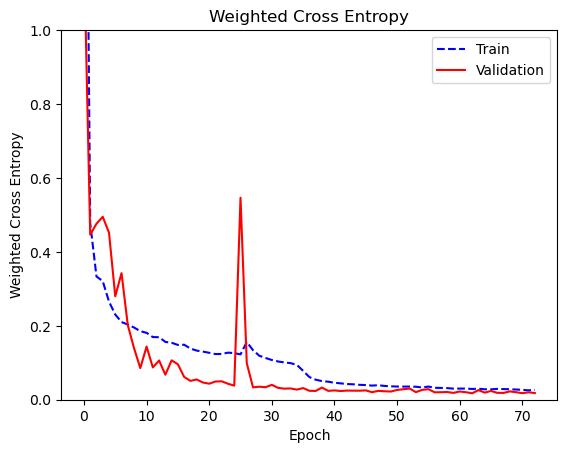

In [13]:
import matplotlib.pyplot as plt

real_epoch = len(history.history["loss"])
plt.plot(range(real_epoch), history.history["loss"], "b--", label="Train")
plt.plot(range(real_epoch), history.history["val_loss"], "r-", label="Validation")
plt.title("Weighted Cross Entropy")
plt.xlabel("Epoch")
plt.ylabel("Weighted Cross Entropy")
plt.ylim(0, 1)
plt.legend()
plt.show()


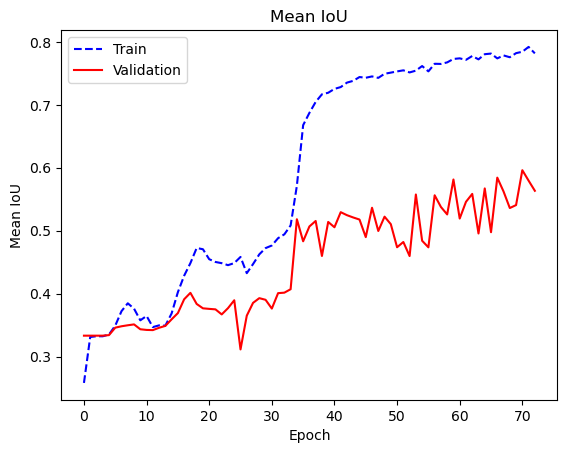

In [14]:
plt.plot(range(real_epoch), history.history["MeanIOU"], "b--", label="Train")
plt.plot(range(real_epoch), history.history["val_MeanIOU"], "r-", label="Validation")
plt.title("Mean IoU")
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.legend()
plt.show()


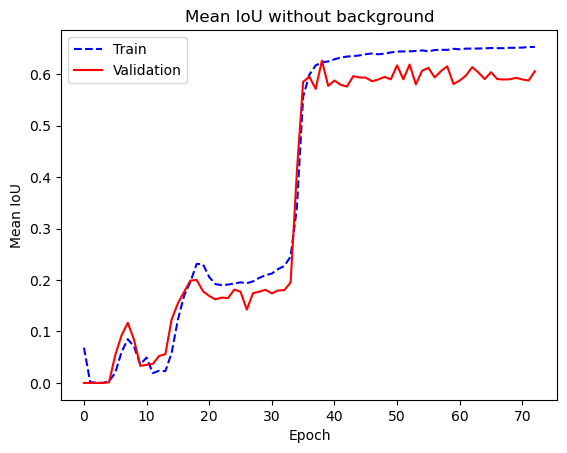

In [15]:
plt.plot(
    range(real_epoch), history.history["MeanIOU_no_background"], "b--", label="Train"
)
plt.plot(
    range(real_epoch),
    history.history["val_MeanIOU_no_background"],
    "r-",
    label="Validation",
)
plt.title("Mean IoU without background")
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.legend()
plt.show()


In [16]:
best_model = tf.keras.models.load_model(
    "model",
    custom_objects={"loss": multiclass_weighted_cross_entropy([10.0, 100.0, 100.0])},
)


### 결과 및 한계

지난 발표보다는 성적이 좋아짐, 그렇지만 지나치게 오버피팅 됨   
Data augmentation 또는 Dataset을 늘리는 방법을 찾아봐야 함  


1/1 [==============================] - 1s 1s/step
float32


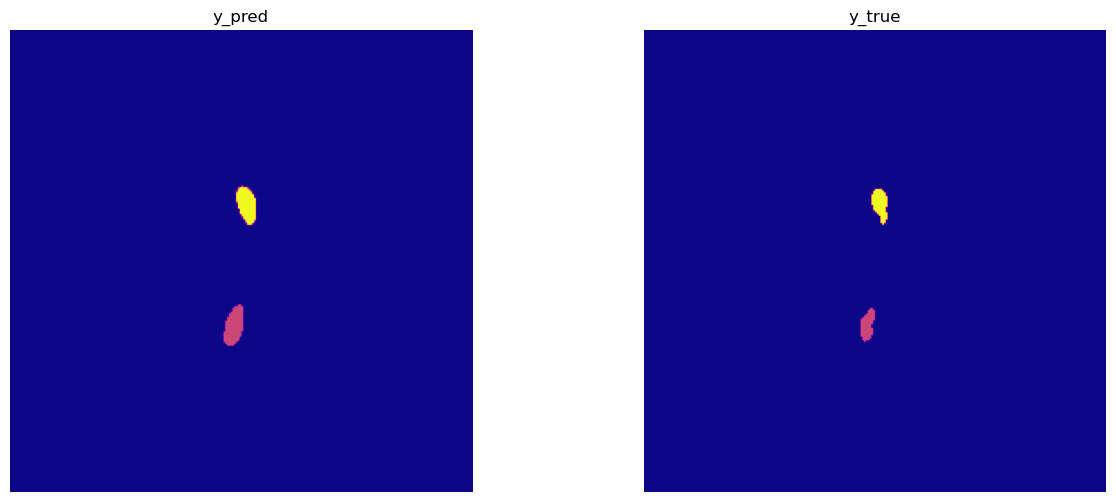

In [17]:
with open("dataset/train/data/HFH_001_057.npy", "rb") as f:
    arr = np.load(f).astype(np.float32)[np.newaxis, ...]
    preds = best_model.predict(arr)
    preds = preds.squeeze().argmax(axis=2)
    print(arr.dtype)
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(preds, cmap="plasma")
    plt.title("y_pred")
    plt.axis("off")

with open("dataset/train/label/HFH_001_057.npy", "rb") as f:
    arr = np.load(f).astype(np.float32)
    target = arr.squeeze().argmax(axis=2)
    plt.subplot(1, 2, 2)
    plt.imshow(target, cmap="plasma")
    plt.title("y_true")
    plt.axis("off")


1/1 [==============================] - 0s 31ms/step
float32


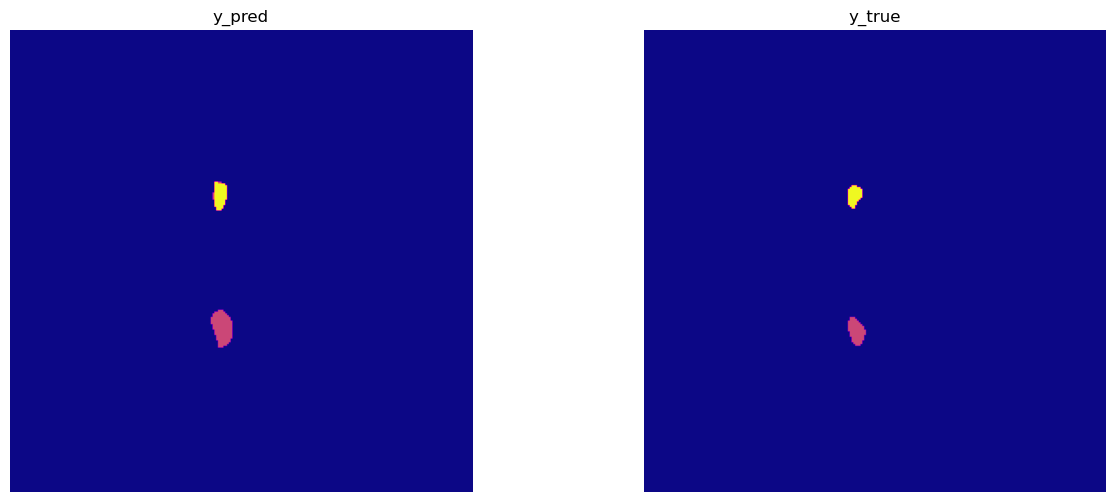

In [18]:
with open("dataset/train/data/HFH_021_057.npy", "rb") as f:
    arr = np.load(f).astype(np.float32)[np.newaxis, ...]
    preds = best_model.predict(arr)
    preds = preds.squeeze().argmax(axis=2)
    print(arr.dtype)
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(preds, cmap="plasma")
    plt.title("y_pred")
    plt.axis("off")

with open("dataset/train/label/HFH_021_057.npy", "rb") as f:
    arr = np.load(f).astype(np.float32)
    target = arr.squeeze().argmax(axis=2)
    plt.subplot(1, 2, 2)
    plt.imshow(target, cmap="plasma")
    plt.title("y_true")
    plt.axis("off")
